# Dog Clasification Project

The goal of this project is to Use AWS Sagemaker to train a pretrained model that can perform image classification by using the Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices. in this Notebook we will use the datasets provided from the class to idetify the dog breed. 


In [ ]:
#Install any packages that you might need
!pip install smdebug

In [4]:
# Import any packages required for the project
import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/Dog-clasification-project"

role = sagemaker.get_execution_role()

## About Dataset
The provided dataset is the dogbreed classification dataset which can be found in the classroom. The image data is divided into train, test and validation datasets. Each contains the 133 classes of the dogs that can be identified.

In [ ]:
# Fetch and upload the data to AWS S3
# Command to download and unzip data

!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

In [5]:
inputs = "s3://sagemaker-us-east-1-510854736858/sagemaker/Dog-clasification-project"
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-510854736858/sagemaker/Dog-clasification-project


## Hyperparameter Tuning
This is the part where we will finetune our pretrained model with hyperparameter tuning. here I chose the learning rate and the batch-size as hyperparameters to tune. 
- The learning rate: is very important, as a wrong / to small learning rate can lead to overfitting, but a too large one might create non-optimal results as well. 
- The batch size: is also very important as it controls the accuracy of the estimate of the error gradient when training neural networks.


In [6]:
# Declare Hyperparameter ranges, metrics etc.
hyperparameters = {"epochs": "5", "batch-size": "32", "lr": "0.001"}

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [7]:
# Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="smdebugger-dogImages-pytorch",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [8]:
# Fit your Hyperparameter Tuner
tuner.fit({"training": inputs}, wait=True)

......................................................................................................................................................................................................................................................................................................!


In [9]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-02-16 20:49:07 Starting - Preparing the instances for training
2023-02-16 20:49:07 Downloading - Downloading input data
2023-02-16 20:49:07 Training - Training image download completed. Training in progress.
2023-02-16 20:49:07 Uploading - Uploading generated training model
2023-02-16 20:49:07 Completed - Resource reused by training job: pytorch-training-230216-2034-003-7731c745


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '"5"',
 'lr': '0.005714973127605987',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"smdebugger-dogImages-pytorch-2023-02-16-20-34-17-347"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-510854736858/smdebugger-dogImages-pytorch-2023-02-16-20-34-17-347/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

we need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:
#Set up debugging and profiling rules and hooks
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [12]:
hyperparameters = {"epochs": "5", "batch-size": "256", "lr": "0.005714973127605987"}

In [ ]:
# Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-mnist-pytorch",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({"training": inputs}, wait=True)

2023-02-16 21:00:27 Starting - Starting the training job...
2023-02-16 21:00:44 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-02-16 21:01:41 Downloading - Downloading input data......
2023-02-16 21:02:42 Training - Downloading the training image...........
2023-02-16 21:05:23 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-16 21:05:23,580 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-16 21:05:23,608 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-16 21:05:23,612 sagemaker_pytorch_container.training INFO     Invoking user training script.
20

## Checking Training Performance
Here we are trying to get the training job object using the training job name and display the training metrics that we were tracking as well as some of the training tensors.

In [71]:
import boto3
import os
import IPython

session = boto3.session.Session()
region = session.region_name

job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Training jobname: {job_name}")
print(f"Region: {region}")

Training jobname: smdebugger-mnist-pytorch-2023-02-16-21-00-26-544
Region: us-east-1


In [72]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.3.bias',
 'gradient/ResNet_fc.3.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [73]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

1

In [74]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

1

In [75]:
# Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


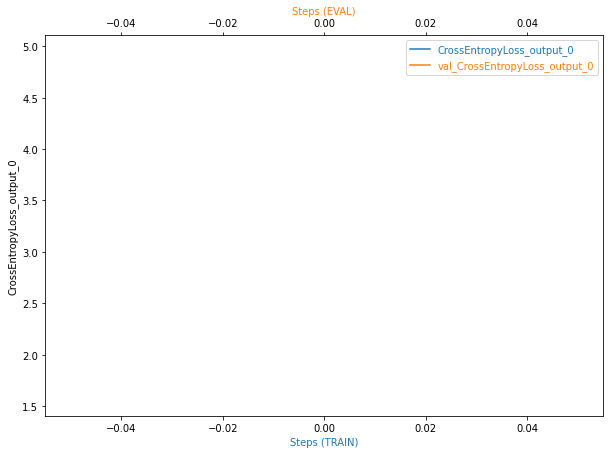

In [76]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [29]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()



ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-510854736858/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-510854736858/smdebugger-mnist-pytorch-2023-02-16-21-00-26-544/profiler-output


Profiler data from system is available


In [30]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-02-16 21:29:10.999 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:33 INFO metrics_reader_base.py:134] Getting 17 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


In [31]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

You will find the profiler report in s3://sagemaker-us-east-1-510854736858/smdebugger-mnist-pytorch-2023-02-16-21-00-26-544/rule-output
2023-02-16 21:17:43     436794 smdebugger-mnist-pytorch-2023-02-16-21-00-26-544/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-02-16 21:17:42     295505 smdebugger-mnist-pytorch-2023-02-16-21-00-26-544/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-02-16 21:17:37        582 smdebugger-mnist-pytorch-2023-02-16-21-00-26-544/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-02-16 21:17:37      37312 smdebugger-mnist-pytorch-2023-02-16-21-00-26-544/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-02-16 21:17:37       2062 smdebugger-mnist-pytorch-2023-02-16-21-00-26-544/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-02-16 21:17:37        327 smdebugger-mnist-pytorch-2023-02-16-21-00-26-544/rule-output/ProfilerRepor

## Model Deploying

In [46]:
# Deploying the model to an endpoint

endpoint = estimator.deploy(initial_instance_count=1, instance_type="ml.t2.medium") # deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: smdebugger-mnist-pytorch-2023-02-16-21-53-07-106
INFO:sagemaker:Creating endpoint with name smdebugger-mnist-pytorch-2023-02-16-21-53-07-106


---------!

In [50]:
predictor = sagemaker.predictor.Predictor('smdebugger-mnist-pytorch-2023-02-16-21-53-07-106', sagemaker_session=sagemaker_session)

In [51]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
from PIL import Image
import numpy as np
import glob
import random
import os

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms

# load and preprocess image to send to endpoint for prediction
data_dir = 'dogImages/test'
testing_images = [file for file in glob.glob(data_dir + "/*/*.jpg")]
inference_image = random.choices(testing_images, k = 1) # randomly select a test image
print(inference_image)

#img_path = Image.open(inference_image[0])
with open(inference_image[0], "rb") as f:
    payload = f.read()
    payload = bytearray(payload)

testing_transform = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img_tensor = testing_transform(image)
img_tensor = img_tensor.unsqueeze(0)
img_tensor_pred = np.array(img_tensor).tobytes()

response = predictor.predict(data = img_tensor_pred)

In [ ]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(10), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

In [ ]:
#Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()